1. Load Dataset

In [1]:
from datasets import list_datasets

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_datasets = list_datasets()
print(f"total dataset len : {len(all_datasets)}")
print(f"head : {all_datasets[:10]}")

/var/folders/nk/mmktldbn3sg0sqwfbx0ss2yc0000gn/T/ipykernel_33052/1931139622.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


total dataset len : 90759
head : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [11]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

2. Dataset to DataFrame

In [12]:
import pandas as pd

In [13]:
emotions.set_format(type="pandas")
df = emotions["train"]
df

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [14]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [17]:
import matplotlib.pyplot as plt

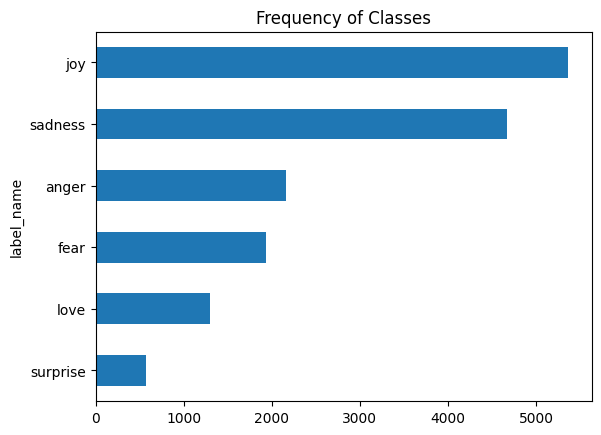

In [18]:
df["label_name"].value_counts(ascending=True).plot.barh()  # barh() : 수평 막대 그래프 / cf) bar() : 수직 막대 그래프
plt.title("Frequency of Classes")
plt.show()

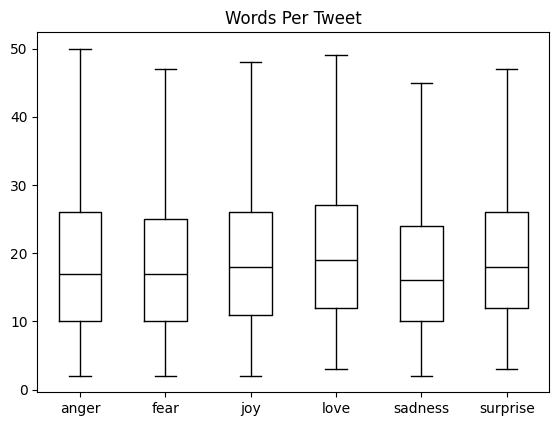

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [20]:
emotions.reset_format()

3. Visualize

In [22]:
import numpy as np
from transformers import AutoTokenizer

In [23]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)   # 자동 클래스

In [24]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [25]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)    # batch_size = 1000

In [26]:
from transformers import AutoModel, AutoTokenizer
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [27]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [28]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 2000/2000 [00:46<00:00, 43.09 examples/s]


In [30]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [31]:
import numpy as np

In [32]:
x_train = np.array(emotions_hidden["train"]["hidden_state"])
x_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

In [34]:
from umap import UMAP

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
x_scaled = MinMaxScaler().fit_transform(x_train)        # [0, 1]

mapper = UMAP(n_components=2, metric="cosine").fit(x_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

In [37]:
df_emb["label"] = y_train

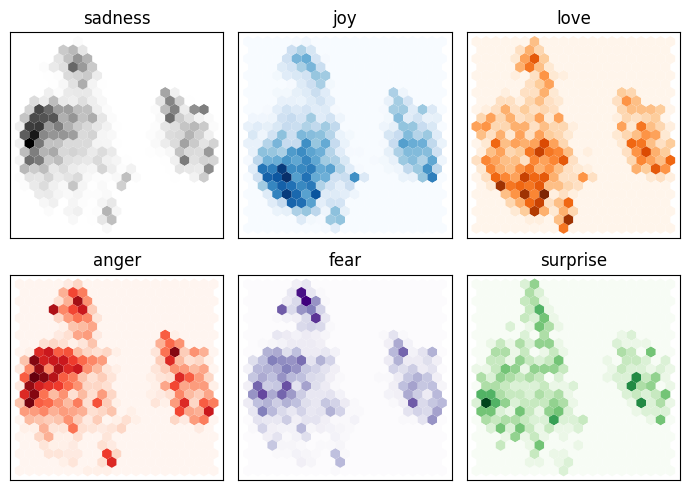

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

In [41]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [43]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

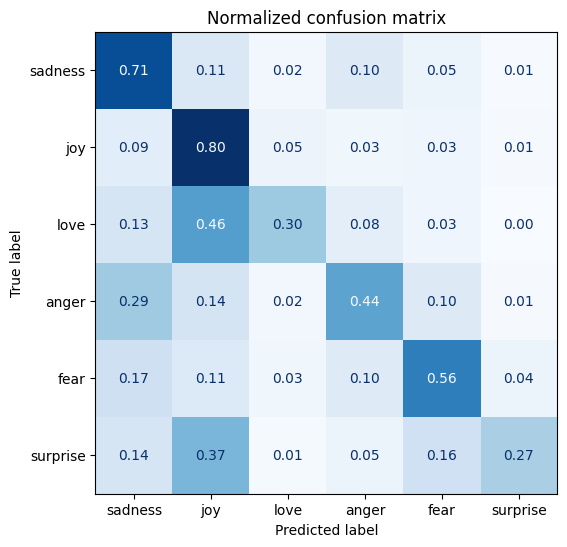

In [44]:
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)